In [1]:
import pandas as pd
import re
import random
import ast
import numpy as np
import scipy.stats as stats 
from scipy.spatial import distance
import statsmodels.stats.multitest as multitest

import statsmodels.stats.api as sms
import seaborn as sns
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import plotly.express as px
import plotly.graph_objects as go
import os, glob
import sys
import pickle
import itertools
import concurrent.futures
from statsmodels.stats.multitest import multipletests
from sklearn.decomposition import PCA
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import Lasso, LassoCV
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
import threading
import multiprocessing
from concurrent.futures import ThreadPoolExecutor
import queue
from stargazer.stargazer import Stargazer, LineLocation

from tqdm import tqdm

plt.rcParams["font.family"] = "Times New Roman"

import warnings
warnings.filterwarnings("ignore")

# Read in the data

In [2]:
full_multi_task_data = pd.read_csv('all_multi_task_wave_data.txt')

In [3]:
full_multi_task_data = full_multi_task_data.rename(columns = {"task": "task_name"})

In [4]:
# set the score to the best score across repeated attempts, in cases where it saved multiple times
full_multi_task_data = full_multi_task_data.groupby('stageId').apply(lambda x: x.loc[x['score'].idxmax()]).reset_index(drop=True)

In [5]:
# task map
task_map = pd.read_csv('../features/task-mapping/task_map.csv')
task_map = task_map.rename(columns = {"task": "task_name"})

In [6]:
task_name_mapping = {
    "Sudoku": "Sudoku",
    "Moral Reasoning": "Moral Reasoning (Disciplinary Action Case)",
    "Wolf Goat Cabbage": "Wolf, goat and cabbage transfer",
    "Guess the Correlation": "Guessing the correlation",
    "Writing Story": "Writing story",
    "Room Assignment": "Room assignment task",
    "Allocating Resources": "Allocating resources to programs",
    "Divergent Association": "Divergent Association Task",
    "Word Construction": "Word construction from a subset of letters",
    "Whac a Mole": "Whac-A-Mole",
    "Random Dot Motion": "Random dot motion",
    "Recall Association": "Recall association",
    "Recall Word Lists": "Recall word lists",
    "Typing": "Typing game",
    "Unscramble Words": "Unscramble words (anagrams)",
    "WildCam": "Wildcam Gorongosa (Zooniverse)",
    "Advertisement Writing": "Advertisement writing",
    "Putting Food Into Categories": "Putting food into categories"
}

task_map = task_map.rename(
    columns = {
        "Q1concept_behav": "Conceptual-Behavioral",
        "Q3type_1_planning": "Type 1 (Planning)",
        "Q4type_2_generate": "Type 2 (Generate)",
        "Q6type_5_cc": "Type 5 (Cognitive Conflict)",
        "Q7type_7_battle": "Type 7 (Battle)",
        "Q8type_8_performance": "Type 8 (Performance)",
        "Q9divisible_unitary": "Divisible-Unitary",
        "Q10maximizing": "Maximizing",
        "Q11optimizing": "Optimizing",
        "Q13outcome_multip": "Outcome Multiplicity",
        "Q14sol_scheme_mul": "Solution Scheme Multiplicity",
        "Q15dec_verifiability": "Decision Verifiability",
        "Q16shared_knowledge": "Shared Knowledge",
        "Q17within_sys_sol": "Within-System Solution",
        "Q18ans_recog": "Answer Recognizability",
        "Q19time_solvability": "Time Solvability",
        "Q20type_3_type_4": "Type 3 and Type 4 (Objective Correctness)",
        "Q22confl_tradeoffs": "Conflicting Tradeoffs",
        "Q23ss_out_uncert": "Solution Scheme Outcome Uncertainty",
        "Q24eureka_question": "Eureka Question",
        "Q2intel_manip_1" : "Intellectual-Manipulative",
        "Q21intellective_judg_1" : "Intellective-Judgmental",
        "Q5creativity_input_1" : "Creativity Input",
        "Q25_type6_mixed_motive" : "Type 6 (Mixed-Motive)"
    }
)

In [7]:
full_multi_task_data.loc[:, "task_name"] = full_multi_task_data["task_name"].replace(task_name_mapping)

In [8]:
task_cols_to_use = task_map.drop(["task_name", "Type 6 (Mixed-Motive)"], axis = 1).columns

In [9]:
# merge the multi-task data with the task map
full_multi_task_data = pd.merge(left = full_multi_task_data, right = task_map, on = "task_name", how = "left")

In [10]:
communication_features = pd.read_csv("./tpm_outputs/conv/full_multi_task_messages_conversation_level.csv")
communication_features = communication_features.rename(columns={"conversation_num": "stageId"})
communication_features.columns
communication_features = communication_features.drop(columns = ['speaker_nickname', 'message',
       'timestamp', 'message_original', 'message_lower_with_punc'], axis = 1)

In [11]:
COMMS_DVS = ["turn_taking_index", "gini_coefficient_sum_num_messages", "sum_num_messages", "average_positive_bert", "team_burstiness"]

# Final Cleaned Datasets

## Task Sets: (1) Wave 1 Only; (2) All 20 Tasks
- `team_multi_task_wave1`
- `team_multi_task_full`

## Communication Features
We examine 5 communication features:
- Turn-Taking
- Gini Coefficient
- Total Number of Messages
- Positivity
- Burstiness

When analyzed in the context of the two different task sets, we get:

- `team_multi_task_comms_wave1`
- `team_multi_task_comms_full`

In [12]:
team_multi_task_full = full_multi_task_data[full_multi_task_data["playerCount"]>1]
print(len(team_multi_task_full))

3486


In [13]:
team_multi_task_wave1 = team_multi_task_full[team_multi_task_full["wave"]==1]
print(len(team_multi_task_wave1))

1772


In [14]:
team_multi_task_comms_full = pd.merge(communication_features, team_multi_task_full, on = "stageId", how = "inner")
print(len(team_multi_task_comms_full))

1858


In [15]:
team_multi_task_comms_wave1 = pd.merge(communication_features, team_multi_task_wave1, on = "stageId", how = "inner")
print(len(team_multi_task_comms_wave1))

1021


In [16]:
# Design decision: Drop all cases where the communication features are missing
team_multi_task_comms_full.dropna(subset = COMMS_DVS, inplace = True)
team_multi_task_comms_wave1.dropna(subset = COMMS_DVS, inplace = True)
print(len(team_multi_task_comms_full))
print(len(team_multi_task_comms_wave1))

1661
928


## Add in Composition Features

In [17]:
players_per_stage = team_multi_task_full[["stageId", "playerIds"]]

In [18]:
players_1 = pd.read_csv('players_wave1_epoch1.csv')
players_2 = pd.read_csv('players_wave1_epoch2.csv')
players_wave2 = pd.read_csv('players_wave_2.csv')
players_wave3 = pd.read_csv('players_wave_3.csv')

players = pd.concat([players_1, players_2, players_wave2, players_wave3])
player_workerIds = players[["_id", "id"]].dropna().rename(columns = {"_id": "playerId", "id": "WorkerId"})
# parse out the first part of WorkerId
player_workerIds["WorkerId"] = player_workerIds["WorkerId"].str.split(" ").str[0]

In [19]:
# match playerIds to players_per_stage based on whether data.playerIds CONTAINS the playerId
stage_id_to_player_and_worker = pd.DataFrame(columns=["stageId", "playerId", "WorkerId"])

# Use tqdm to create a progress bar for the loop
for player in tqdm(player_workerIds["playerId"], desc="Matching playerIds"):
    stages_played = players_per_stage[players_per_stage["playerIds"].str.contains(player)].copy()

    if len(stages_played) > 0:
        # Set "playerId" column to the player's id
        stages_played["playerId"] = player
        # Get workerId of player
        workerId = player_workerIds.loc[player_workerIds["playerId"] == player, "WorkerId"].values[0]
        # Set "WorkerId" column to the player's id
        stages_played["WorkerId"] = workerId
        new_player_rows = stages_played[["stageId", "playerId", "WorkerId"]]
        stage_id_to_player_and_worker = pd.concat([stage_id_to_player_and_worker, new_player_rows], axis=0)

Matching playerIds: 100%|██████████| 2839/2839 [00:02<00:00, 1340.44it/s]


In [20]:
# heres the information we have about all the workers
panel = pd.read_csv('individuals.csv')

In [21]:
panel_filtered = panel[["WorkerId", "CRT", "RME"]]

In [22]:
individual_workers_by_stageId = pd.merge(left = stage_id_to_player_and_worker, right = panel_filtered, on = "WorkerId", how = "left")
composition_by_stageId = individual_workers_by_stageId[["stageId", "CRT", "RME"]].groupby("stageId").mean().reset_index()

# Design decision: Drop cases where we don't have information on the participants.
# many of these are actually test datapoints (e.g., Mark and Eric)
print("Dropping " + str(len(composition_by_stageId) - len(composition_by_stageId.dropna())) + " rows.")
composition_by_stageId = composition_by_stageId.dropna()

Dropping 28 rows.


### Let's add in the composition features. 
A few teams don't have valid composition data, so let's separately store the dataframe and get a sense of what the differences are.

In [23]:
team_composition_by_stageId = composition_by_stageId[composition_by_stageId['stageId'].isin(team_multi_task_full['stageId'])]

In [24]:
# merge the composition with the rest of the data
team_multi_task_full_with_composition = pd.merge(team_multi_task_full, team_composition_by_stageId, on = "stageId", how = "inner")
team_multi_task_wave1_with_composition = pd.merge(team_multi_task_wave1, team_composition_by_stageId, on = "stageId", how = "inner")
team_multi_task_comms_full_with_composition = pd.merge(team_multi_task_comms_full, team_composition_by_stageId, on = "stageId", how = "inner")
team_multi_task_comms_wave1_with_composition = pd.merge(team_multi_task_comms_wave1, team_composition_by_stageId, on = "stageId", how = "inner")

In [25]:
print("Difference in # Rows for Multi-Task (Full; 20 Tasks)")
print(len(team_multi_task_full) - len(team_multi_task_full_with_composition))
print("Difference in # Rows for Multi-Task (Wave 1; 10 Tasks)")
print(len(team_multi_task_wave1) - len(team_multi_task_wave1_with_composition))
print("Difference in # Rows for Multi-Task w/ Communication (Wave 1; 10 Tasks)")
print(len(team_multi_task_comms_full) - len(team_multi_task_comms_full_with_composition))
print("Difference in # Rows for Multi-Task w/ Communication (Wave 1; 10 Tasks)")
print(len(team_multi_task_comms_wave1) - len(team_multi_task_comms_wave1_with_composition))

Difference in # Rows for Multi-Task (Full; 20 Tasks)
28
Difference in # Rows for Multi-Task (Wave 1; 10 Tasks)
28
Difference in # Rows for Multi-Task w/ Communication (Wave 1; 10 Tasks)
6
Difference in # Rows for Multi-Task w/ Communication (Wave 1; 10 Tasks)
6


### Add Interactions Between Composition and Task Features

In [26]:
def get_task_composition_interactions(df):
    for task_col in task_cols_to_use:
        # intersect with team size
        task_col_x_teamsize = df[task_col]*df["playerCount"]
        df.loc[:, task_col + " x playerCount"] = task_col_x_teamsize

        # intersect with CRT
        task_col_x_CRT = df[task_col]*df["CRT"]
        df.loc[:, task_col + " x CRT"] = task_col_x_CRT

        # intersect with RME
        task_col_x_RME = df[task_col]*df["RME"]
        df.loc[:, task_col + " x RME"] = task_col_x_RME
    
    return df

In [27]:
team_multi_task_full_with_composition = get_task_composition_interactions(team_multi_task_full_with_composition)
team_multi_task_wave1_with_composition = get_task_composition_interactions(team_multi_task_wave1_with_composition)
team_multi_task_comms_full_with_composition = get_task_composition_interactions(team_multi_task_comms_full_with_composition)
team_multi_task_comms_wave1_with_composition = get_task_composition_interactions(team_multi_task_comms_wave1_with_composition)

In [28]:
# get the relevant columns so that we can select them easily
task_cols_and_derivatives = list(set(list(task_cols_to_use) + [col for col in team_multi_task_full_with_composition.columns if "x" in col]))
all_features_and_interactions = task_cols_and_derivatives + ["CRT", "RME", "playerCount"] + ["High", "Medium"]
controls = ["High", "Medium"] # these are dummy variables for the high and medium conditions; we won't standardize them

## Additional Preprocessing
- Standardize all task columns
- Standardize all composition variables
- Standardize all interaction terms
- Standardize all dependent variables

In [29]:
cols_to_use = ["score"] + list(task_cols_to_use)
cols_to_use_with_comms = COMMS_DVS + ["score"] + list(task_cols_to_use)

In [30]:
# these are our dataframes *without* composition or interactions
team_multi_task_full[cols_to_use] = StandardScaler().fit_transform(team_multi_task_full[cols_to_use])
team_multi_task_wave1[cols_to_use] = StandardScaler().fit_transform(team_multi_task_wave1[cols_to_use])
team_multi_task_comms_full[cols_to_use_with_comms] = StandardScaler().fit_transform(team_multi_task_comms_full[cols_to_use_with_comms])
team_multi_task_comms_wave1[cols_to_use_with_comms] = StandardScaler().fit_transform(team_multi_task_comms_wave1[cols_to_use_with_comms])

# these are our dataframes *with* composition and interactions
team_multi_task_full_with_composition[all_features_and_interactions + ["score"]] = StandardScaler().fit_transform(team_multi_task_full_with_composition[all_features_and_interactions + ["score"]])
team_multi_task_wave1_with_composition[all_features_and_interactions + ["score"]] = StandardScaler().fit_transform(team_multi_task_wave1_with_composition[all_features_and_interactions + ["score"]])
team_multi_task_comms_full_with_composition[all_features_and_interactions + COMMS_DVS + ["score"]] = StandardScaler().fit_transform(team_multi_task_comms_full_with_composition[all_features_and_interactions + COMMS_DVS + ["score"]])
team_multi_task_comms_wave1_with_composition[all_features_and_interactions + COMMS_DVS + ["score"]] = StandardScaler().fit_transform(team_multi_task_comms_wave1_with_composition[all_features_and_interactions + COMMS_DVS + ["score"]])

# Define Functions for Calculating Q^2

In [31]:
def reshape_x_y(x, y):
    if(isinstance(x, pd.Series)):
        x = np.asarray(x).reshape(-1, 1)
    else:
        x = np.asarray(x)
    
    y = np.asarray(y).reshape(-1, 1)
    return(x, y)

In [32]:
def q2_task_holdout_helper(x_train, x_test, y_train, y_test, estimator):
    
    # some reshaping
    x_train_array, y_train_array = reshape_x_y(x_train, y_train)
    x_test_array, y_test_array = reshape_x_y(x_test, y_test)

    # print("Training data: ", pd.DataFrame(x_train_array).head())
    # print("Testing data: ", pd.DataFrame(x_test_array).head())

    # Fit the model and get the error
    fitted_model = estimator.fit(X=x_train_array, y=y_train_array.ravel())
    
    # save prediction error
    prediction = fitted_model.predict(x_test_array)

    # flatten all arrays
    y_test_array = np.asarray(y_test_array).flatten()
    prediction = np.asarray(prediction).flatten()

    # print("y test array", y_test_array)
    # print("prediction", prediction)

    squared_model_prediction_error = (y_test_array - prediction) ** 2

    # save total error for this fold
    squared_average_prediction_error = (y_test_array - np.mean(y_train_array)) ** 2

    return squared_model_prediction_error, squared_average_prediction_error

In [33]:
"""
This is the version of q^2 that holds out EVERYTHING associated with a given task

It trains on all task instances from the "seen" classes, and it tests on task instances of held-out (unseen) classes.

NOTE: this version of the function assumes that x and y are passed in with a column called "task_name"
"""

def get_q2(y, x, estimator = Lasso(), num_task_holdouts = 1):

    squared_model_prediction_errors = []
    squared_average_prediction_errors = []

    num_total_tasks = x["task_name"].nunique()

    # randomly hold out `num_task_holdouts`
    all_possible_task_combos = list(itertools.combinations((x["task_name"].unique()), num_total_tasks - num_task_holdouts))
    
    for sample in all_possible_task_combos:

        # print("Sample:", sample)
        # print("Held out:", x[~x["task_name"].isin(sample)]["task_name"].unique())

        x_train_tasks = x[x["task_name"].isin(sample)].drop("task_name", axis = 1)
        x_test_tasks = x[~x["task_name"].isin(sample)].drop("task_name", axis = 1)

        y_train_tasks = y[y["task_name"].isin(sample)].drop("task_name", axis = 1)
        y_test_tasks = y[~y["task_name"].isin(sample)].drop("task_name", axis = 1)

        # get evaluation score by training on the training tasks and evaluating on the holdout tasks
        squared_model_prediction_error, squared_average_prediction_error = q2_task_holdout_helper(x_train_tasks, x_test_tasks, y_train_tasks, y_test_tasks, estimator)
        
        squared_model_prediction_errors.append(squared_model_prediction_error)
        squared_average_prediction_errors.append(squared_average_prediction_error)

    squared_model_prediction_error = np.asarray(squared_model_prediction_error).flatten()
    squared_average_prediction_error = np.asarray(squared_average_prediction_error).flatten()

    return 1 - (np.sum(squared_model_prediction_error) / np.sum(squared_average_prediction_error))


# Set up "Us versus McGrath"

In [34]:
mcgrath_colnames = [col for col in task_map.columns if "Type" in col]
# remove type 6, as it is not relevant for our data
mcgrath_colnames.remove('Type 6 (Mixed-Motive)')

In [35]:
def get_mcgrath_categorical(df):
    mcgrath_categorical_buckets = {}
    
    # first, convert everything into one of mcgrath's categories
    for i in range(len(df)):
        task_vec_mcgrath = df[mcgrath_colnames].iloc[i][1:]
        task_name = df.iloc[i]["task_name"]
        task_type = task_vec_mcgrath.idxmax()
        type_val = task_vec_mcgrath[task_type]
        if task_type == "Type 3 and Type 4 (Objective Correctness)":
            task_type = "Type 3 (Intellective)" if type_val > 0.5 else "Type 4 (Decision-Making)"

        mcgrath_categorical_buckets[task_name] = task_type
        
    mcgrath_df = pd.DataFrame({
        "task_name": mcgrath_categorical_buckets.keys(),
        "mcgrath_category": mcgrath_categorical_buckets.values()
    })

    mcgrath_df_categorical = pd.concat([mcgrath_df["task_name"], pd.get_dummies(mcgrath_df["mcgrath_category"], dtype= int).add_suffix('_cat')], axis = 1)

    mcgrath_categorical = list(mcgrath_df_categorical.columns)
    mcgrath_categorical.remove("task_name")
    
    # after calculating the categories, return the dataframe
    return (df.merge(mcgrath_df_categorical, on = "task_name"), mcgrath_categorical)

In [36]:
# OUR FOUR DATASETS ARE:
# team_multi_task_full, team_multi_task_wave1
# team_multi_task_comms_full, team_multi_task_comms_wave1

def get_mcgrath_comparisons(datasets, dvs):
    
    comparison_dict_list = [{} for i in range(len(datasets))]
    
    for i, dataset in enumerate(datasets):
        comparison_dict = comparison_dict_list[i]
        
        dataset, mcgrath_categorical = get_mcgrath_categorical(dataset)

        for dv in dvs:
            comparison_dict[dv] = {}
            comparison_dict[dv]["mcgrath_continuous"] = get_q2(dataset[[dv, "task_name"]], dataset[mcgrath_colnames + ["playerCount", "Low", "Medium", "task_name"]], estimator = LinearRegression())
            comparison_dict[dv]["mcgrath_categorical"] = get_q2(dataset[[dv, "task_name"]], dataset[mcgrath_categorical + ["playerCount", "Low", "Medium", "task_name"]], estimator = LinearRegression())
            comparison_dict[dv]["all_features"] = get_q2(dataset[[dv, "task_name"]], dataset[list(task_cols_to_use) + ["playerCount", "Low", "Medium", "task_name"]], estimator = LinearRegression())
            
    return comparison_dict_list

Our dictionaries of looking at McGrath versus the rest:
1. `mcgrath_comparisons_full`
2. `mcgrath_comparisons_wave1`
3. `mcgrath_comparisons_conv_full`
4. `mcgrath_comparisons_conv_wave1`

In [37]:
mcgrath_comparisons_full, mcgrath_comparisons_wave1 = get_mcgrath_comparisons([team_multi_task_full, team_multi_task_wave1], ["score"])

In [38]:
mcgrath_comparisons_conv_full, mcgrath_comparisons_conv_wave1 = get_mcgrath_comparisons([team_multi_task_comms_full, team_multi_task_comms_wave1], COMMS_DVS)

In [39]:
# example of looking at the dictionary
mcgrath_comparisons_full

{'score': {'mcgrath_continuous': 0.1279738531043504,
  'mcgrath_categorical': 0.22713504284140085,
  'all_features': -1.8457581917629178e+24}}

In [40]:
mcgrath_comparisons_conv_full

{'turn_taking_index': {'mcgrath_continuous': -0.10086506025107655,
  'mcgrath_categorical': -0.30942262913147345,
  'all_features': -2.935734540001007e+24},
 'gini_coefficient_sum_num_messages': {'mcgrath_continuous': 0.10584945342008023,
  'mcgrath_categorical': -0.01720721968120187,
  'all_features': -5.876082187551697e+24},
 'sum_num_messages': {'mcgrath_continuous': 0.08816867179049426,
  'mcgrath_categorical': 0.021326173357139155,
  'all_features': -1.0596377409687522e+23},
 'average_positive_bert': {'mcgrath_continuous': -0.0709927901951859,
  'mcgrath_categorical': -0.1238947362617091,
  'all_features': -1.2271784278334418e+25},
 'team_burstiness': {'mcgrath_continuous': -0.009238366370673434,
  'mcgrath_categorical': -0.01338157177536825,
  'all_features': -1.1658863101055347e+25}}

# Main Visuals

In [41]:
def get_robust_se(model):
    # Obtain robust covariance results
    robust_cov = model.get_robustcov_results(cov_type='HC3')  # Heteroskedasticity robust covariance
    # Extract standard errors and convert to a Pandas Series with coefficient names as index
    robust_se = pd.Series(robust_cov.bse, index=model.params.index)
    return robust_se

def correct_p_values(task_lm, task_crt_lm, task_rme_lm, task_playercount_lm, giant_lm):
    # Get robust standard errors for each model
    task_lm.bse_corrected = get_robust_se(task_lm)
    task_crt_lm.bse_corrected = get_robust_se(task_crt_lm)
    task_rme_lm.bse_corrected = get_robust_se(task_rme_lm)
    task_playercount_lm.bse_corrected = get_robust_se(task_playercount_lm)
    giant_lm.bse_corrected = get_robust_se(giant_lm)

    # Corrected p-values
    p_values = [task_lm.pvalues, task_crt_lm.pvalues, task_rme_lm.pvalues, task_playercount_lm.pvalues, giant_lm.pvalues]
    all_p_values = [p for sublist in p_values for p in sublist]
    
    # Apply Benjamini-Hochberg correction
    rejected, corrected_p_values, _, _ = multitest.multipletests(all_p_values, alpha=0.05, method='fdr_bh')

    len_task = len(task_lm.pvalues)
    len_task_crt = len(task_crt_lm.pvalues)
    len_task_rme = len(task_rme_lm.pvalues)
    len_task_playercount = len(task_playercount_lm.pvalues)

    corrected_p_values_task = pd.Series(corrected_p_values[:len_task], index=task_lm.pvalues.index)
    corrected_p_values_task_crt = pd.Series(corrected_p_values[len_task:len_task+len_task_crt], index=task_crt_lm.pvalues.index)
    corrected_p_values_task_rme = pd.Series(corrected_p_values[len_task+len_task_crt:len_task+len_task_crt+len_task_rme], index=task_rme_lm.pvalues.index)
    corrected_p_values_task_playercount = pd.Series(corrected_p_values[len_task+len_task_crt+len_task_rme:len_task+len_task_crt+len_task_rme+len_task_playercount], index=task_playercount_lm.pvalues.index)
    corrected_p_values_giant = pd.Series(corrected_p_values[len_task+len_task_crt+len_task_rme+len_task_playercount:], index=giant_lm.pvalues.index)

    task_lm.pvalues_corrected = corrected_p_values_task
    task_crt_lm.pvalues_corrected = corrected_p_values_task_crt
    task_rme_lm.pvalues_corrected = corrected_p_values_task_rme
    task_playercount_lm.pvalues_corrected = corrected_p_values_task_playercount
    giant_lm.pvalues_corrected = corrected_p_values_giant

    return task_lm, task_crt_lm, task_rme_lm, task_playercount_lm, giant_lm

In [42]:
def intensify_color(color, factor=0.5):
    """ Make the color more intense by scaling the RGB values. """
    color_rgb = mcolors.to_rgb(color)
    return tuple(min(1, c * factor) for c in color_rgb)

In [43]:
def plot_models(models, features_to_plot, model_names, colors, title, figsize = (8, 10), pval_thresh = 0.05, y_jitter = 1.3):
    # Create a DataFrame to organize the parameters for easier manipulation
    pvalues_corrected_df = pd.DataFrame([model.pvalues_corrected for model in models], index=model_names).filter(features_to_plot)
    params_df = pd.DataFrame([model.params for model in models], index=model_names).filter(features_to_plot)

    sorted_columns = params_df.sum().sort_values(ascending=False).index

    # order everything by smallest to largest effect size
    params_df = params_df.reindex(columns=sorted_columns)
    pvalues_corrected_df = pvalues_corrected_df.reindex(columns=sorted_columns)
    stderr_df = pd.DataFrame([model.bse for model in models], index=model_names).reindex(columns=sorted_columns)
    stderr_corrected_df = pd.DataFrame([model.bse_corrected for model in models], index=model_names).reindex(columns=sorted_columns)
    
    fig, ax = plt.subplots(figsize=figsize)
    y_positions = np.arange(len(params_df.columns)) * 10 # spread out y-positions

    #### THIS PLOTS THE REGULAR THING ###
    for i, model_name in enumerate(model_names):
        pvalues_corrected = pvalues_corrected_df.loc[model_name]
        means = params_df.loc[model_name]
        errors = stderr_df.loc[model_name]
        errors_corrected = stderr_corrected_df.loc[model_name]
        plot_color = colors[i]

        # Plot uncorrected errors with colored solid lines
        ax.errorbar(means, y_positions + i * y_jitter, xerr=errors, fmt='o', color=plot_color, capsize=1, label=f'{model_name}')# (SE Uncorrected)')

        # Plot corrected errors with gray broken lines
        ax.errorbar(means, y_positions + i * y_jitter, xerr=errors_corrected, fmt='none', color=intensify_color(plot_color, factor=0.7), capsize=1)# label=f'{model_name} (SE Corrected)')

    ### THIS GRAYS OUT THE NON-SIGNIFICANT ONES ###
    for i, model_name in enumerate(model_names):
        pvalues_corrected = pvalues_corrected_df.loc[model_name]
        means = params_df.loc[model_name]
        errors = stderr_df.loc[model_name]
        errors_corrected = stderr_corrected_df.loc[model_name]

        # Iterate over each point and plot it with its corresponding color based on p-value significance
        for j, (mean, error, error_corrected, pval) in enumerate(zip(means, errors, errors_corrected, pvalues_corrected)):
            plot_color = colors[i] if pval <= pval_thresh else 'lightgray'

            # Plot uncorrected errors with colored solid lines
            ax.errorbar(mean, y_positions[j] + i * y_jitter, xerr=error, fmt='o', color=plot_color, capsize=1)
            # Plot corrected errors with gray broken lines
            ax.errorbar(mean, y_positions[j] + i * y_jitter, xerr=error_corrected, fmt='none', color=intensify_color(plot_color, factor=0.7), capsize=1)
       
    ax.set_title(title)
    ax.set_xlabel('Coefficient Value') 
    ax.set_ylabel('Variables')  
    ax.set_yticks(y_positions + (len(models) - 1) * y_jitter / 2)  
    ax.set_yticklabels(params_df.columns, rotation=45, ha="right")  
    ax.grid(axis='x', linestyle='--', alpha=0.7) 
    if(len(models) > 1): 
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.axvline(x=0, color='r', linestyle='-') 
    plt.show()

In [44]:
def plot_q2_combination_hist(df, mcgrath_dict, col, dv, title_append = ""):
    # keep the dataframe for metrics
    df_for_metrics =  df
    # when plotting, filter the dataframe so that we don't have huge negative values
    df = df[df[col] > -10]

    plt.hist(df[col], bins=40, color="dodgerblue")

    # Vertical lines
    mean_q2 = np.mean(df_for_metrics[col]) # df for metrics is where we'll calculate the mean / max from, but we'll plot the df (in case there's a long tail)
    mcgrath_continuous = mcgrath_dict[dv]["mcgrath_continuous"]
    mcgrath_categorical = mcgrath_dict[dv]["mcgrath_categorical"]
    max_q2 = np.max(df_for_metrics[col])

    plt.axvline(mean_q2, color='salmon', linestyle='dashed', linewidth=1, label='Mean (' + str(np.round(mean_q2, 3)) + ")")
    plt.axvline(mcgrath_continuous, color='limegreen', linestyle='dashed', linewidth=1, label='Continuous McGrath (' + str(np.round(mcgrath_continuous, 3)) + ")")
    plt.axvline(mcgrath_categorical, color='cyan', linestyle='dashed', linewidth=1, label='Categorical McGrath (' + str(np.round(mcgrath_categorical, 3)) + ")")
    plt.axvline(max_q2, color='gold', linestyle='dashed', linewidth=1, label='Max (' + str(np.round(max_q2, 3)) + ")")

    # Labels and title
    plt.title(f'Q^2 for All ({len(df_for_metrics):,}) Task Column Combinations{title_append}')
    plt.ylabel('Number of Task Column Combinations With Value')
    plt.xlabel('Q^2 Value')

    # Legend
    plt.legend()

    # Show plot
    plt.show()

In [45]:
# Print likelihood ratio tests
def print_likelihood_ratio_tests(task_lm, task_crt_lm, task_rme_lm, task_playercount_lm, giant_lm):
    lr_statistic, p_value, df = task_crt_lm.compare_lr_test(task_lm)
    print("Likelihood Ratio Statistic for Task and CRT") # The likelihood ratio which is chisquare distributed with df_diff degrees of freedom.
    print(lr_statistic)
    print("p-value")
    print(p_value)

    lr_statistic, p_value, df = task_rme_lm.compare_lr_test(task_lm)
    print("Likelihood Ratio Statistic for Task and RME") # The likelihood ratio which is chisquare distributed with df_diff degrees of freedom.
    print(lr_statistic)
    print("p-value")
    print(p_value)

    lr_statistic, p_value, df = task_playercount_lm.compare_lr_test(task_lm)
    print("Likelihood Ratio Statistic for Task and PlayerCount") # The likelihood ratio which is chisquare distributed with df_diff degrees of freedom.
    print(lr_statistic)
    print("p-value")
    print(p_value)

In [46]:
comm_dv_translation = {
    "turn_taking_index": "Turn Taking Index",
    "gini_coefficient_sum_num_messages": "Gini Coefficient",
    "sum_num_messages": "Total Number of Messages",
    "average_positive_bert": "Average Message Positivity",
    "team_burstiness": "Team Burstiness"
}

In [47]:
# dictionary to store the different top features selected by the models
top_features_dict = {}

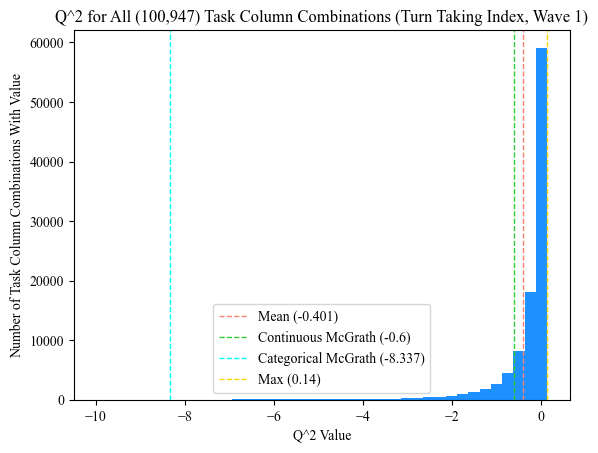

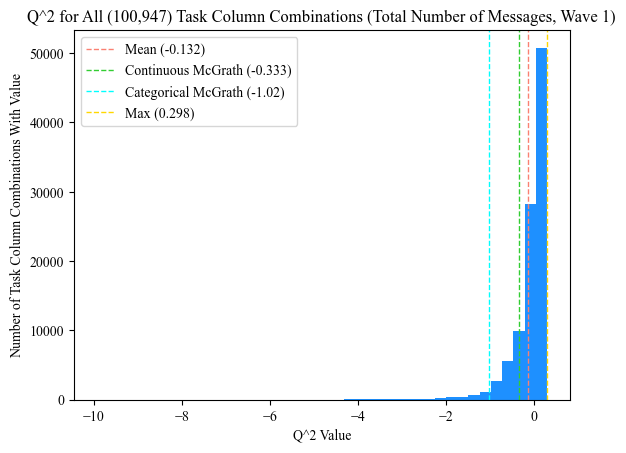

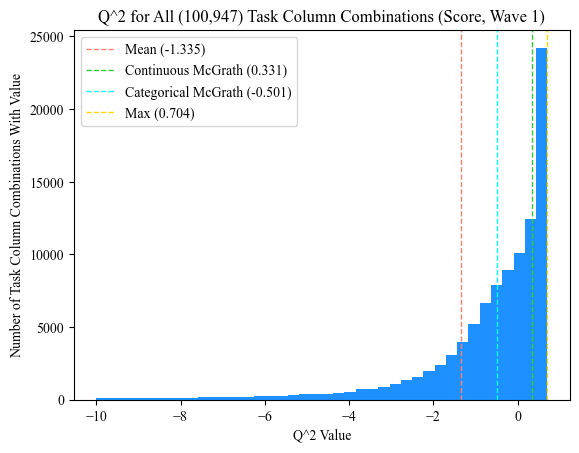

Likelihood Ratio Statistic for Task and CRT
42.760651196284016
p-value
3.7100403062044987e-07
Likelihood Ratio Statistic for Task and RME
14.247481105056067
p-value
0.046950717905697735
Likelihood Ratio Statistic for Task and PlayerCount
61.01336512387752
p-value
9.470537801430543e-11


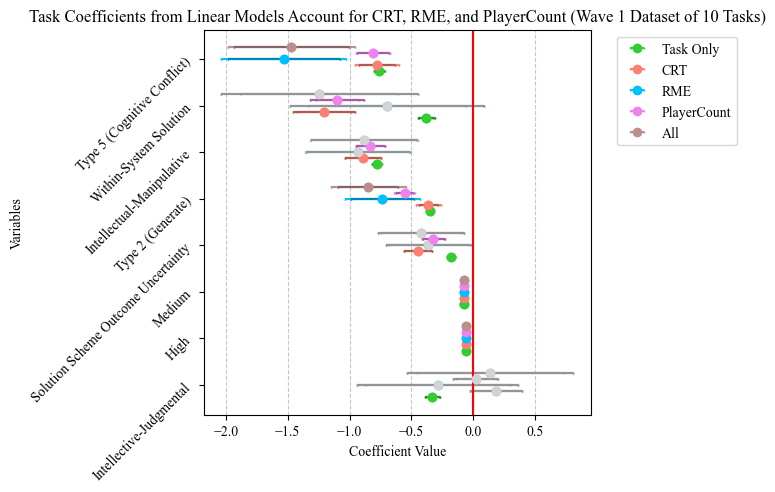

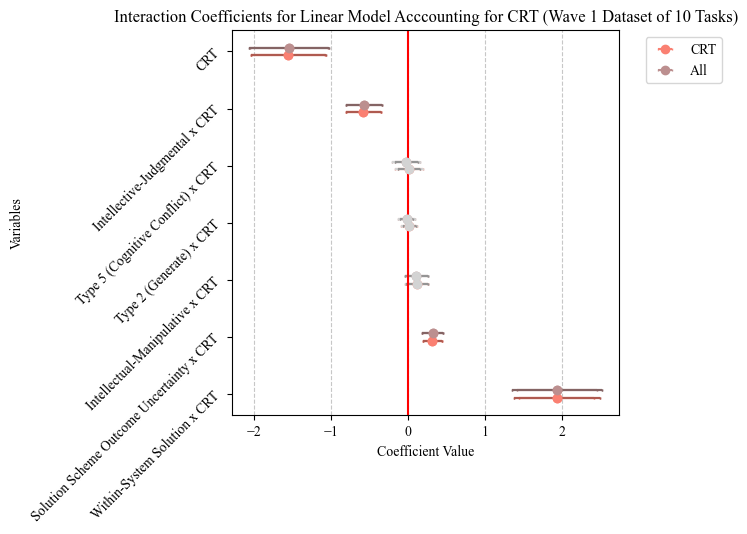

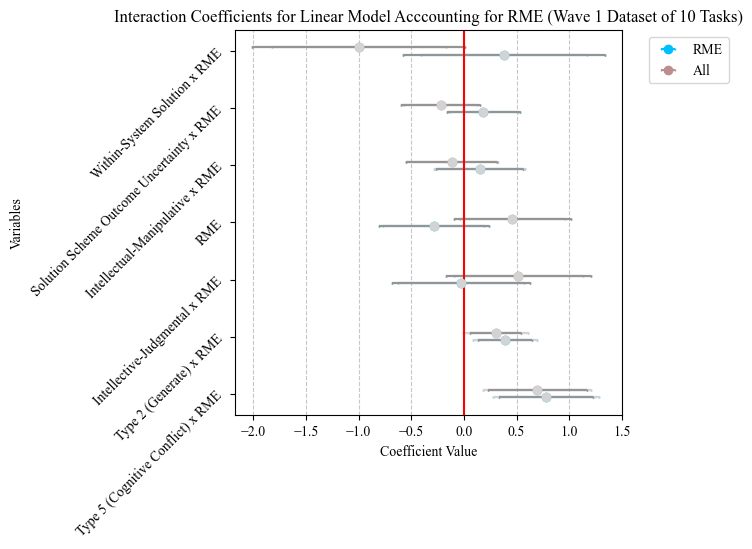

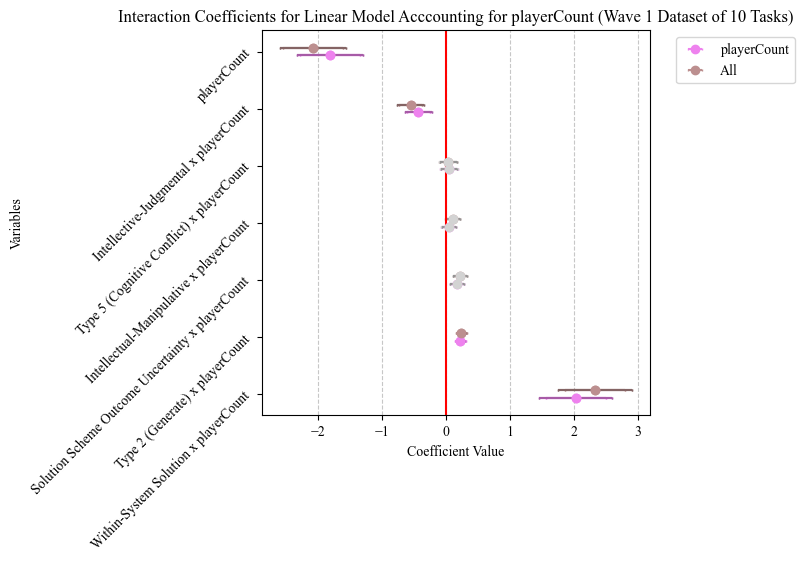

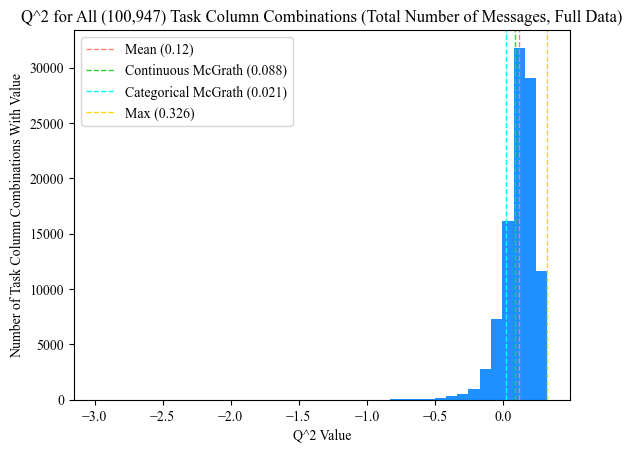

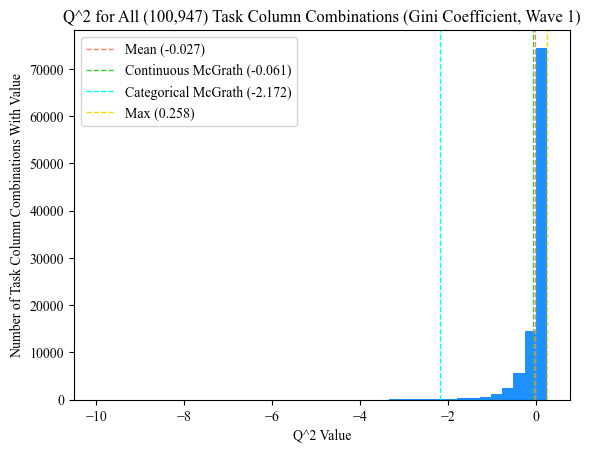

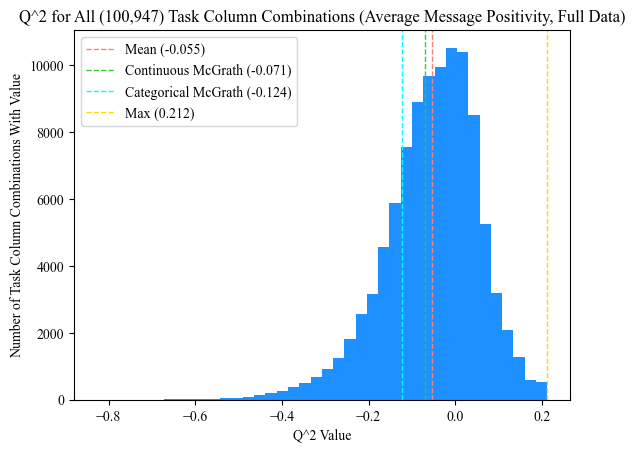

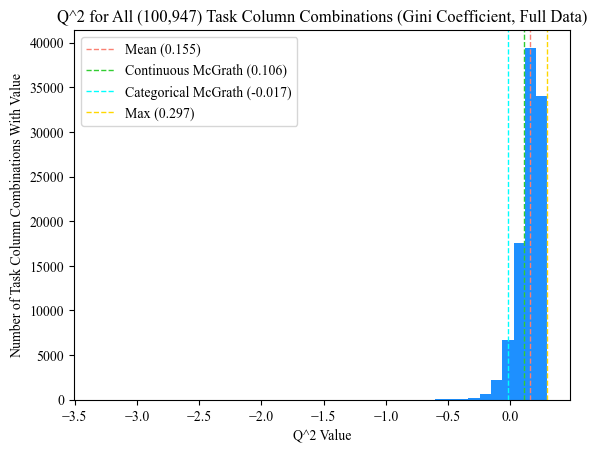

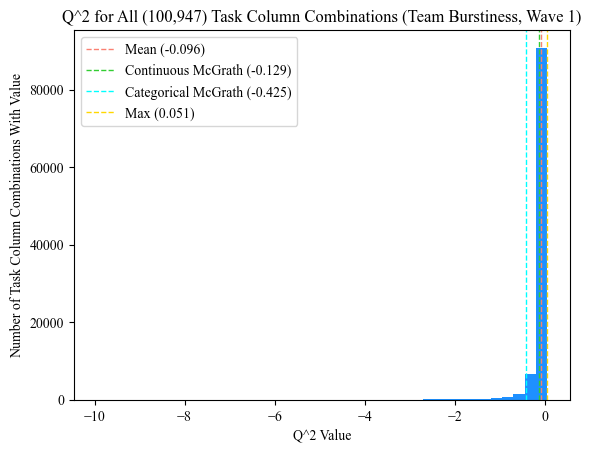

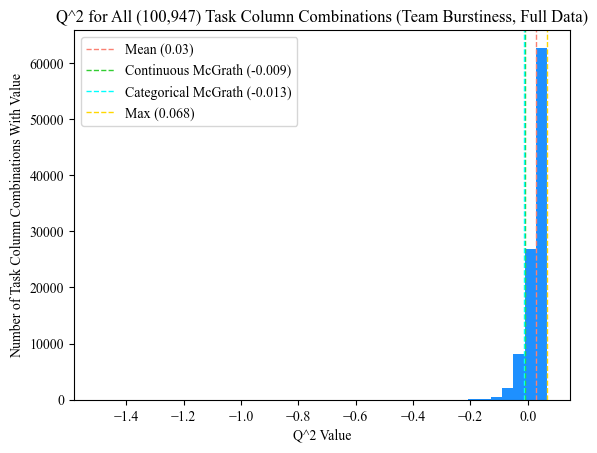

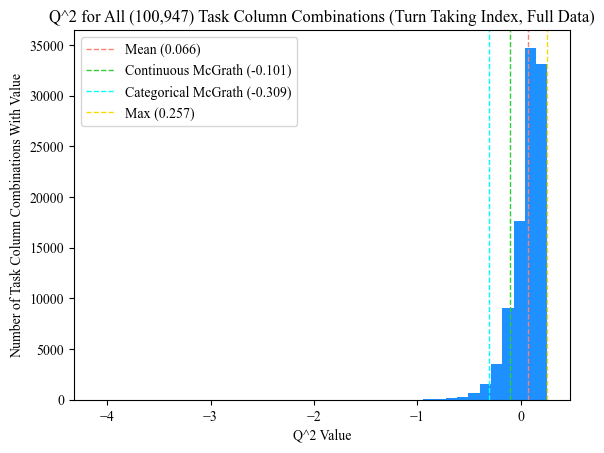

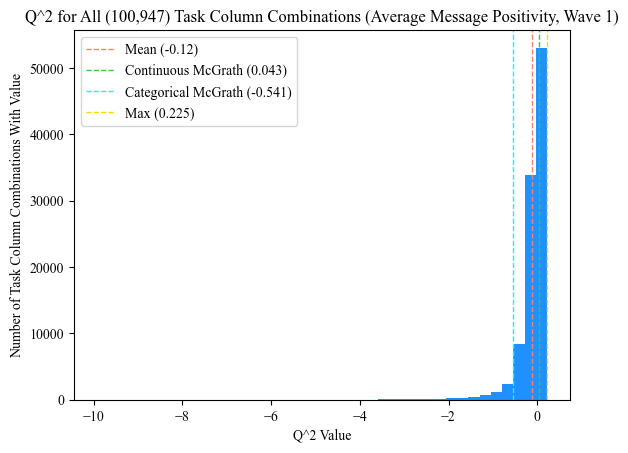

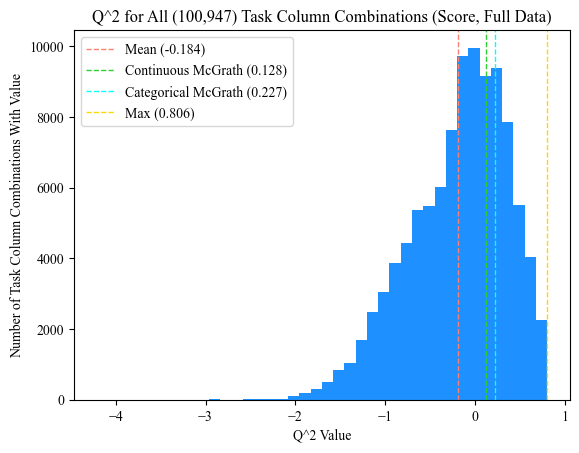

Likelihood Ratio Statistic for Task and CRT
38.765287292533685
p-value
2.16663923854126e-06
Likelihood Ratio Statistic for Task and RME
38.935937574515265
p-value
2.01024659225828e-06
Likelihood Ratio Statistic for Task and PlayerCount
79.2192180858292
p-value
1.98727817288493e-14


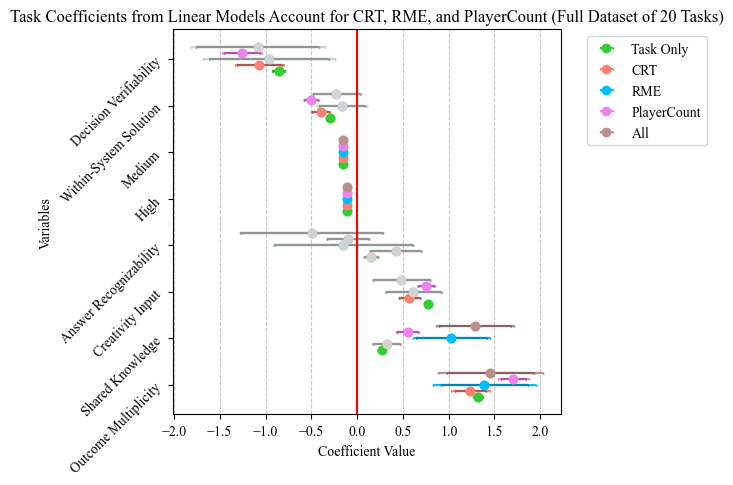

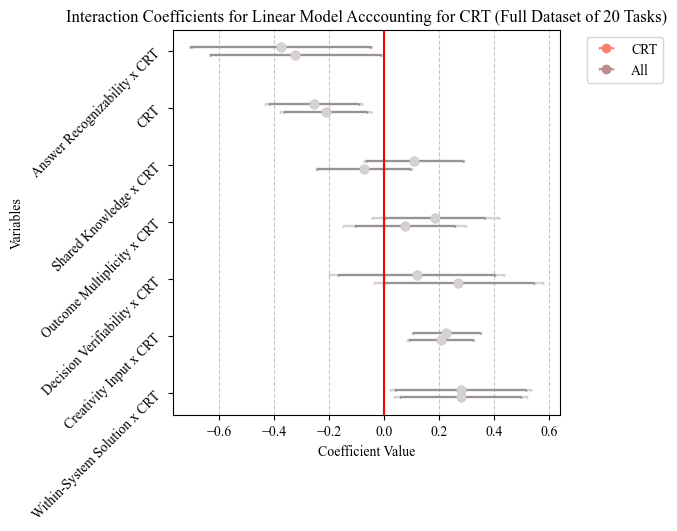

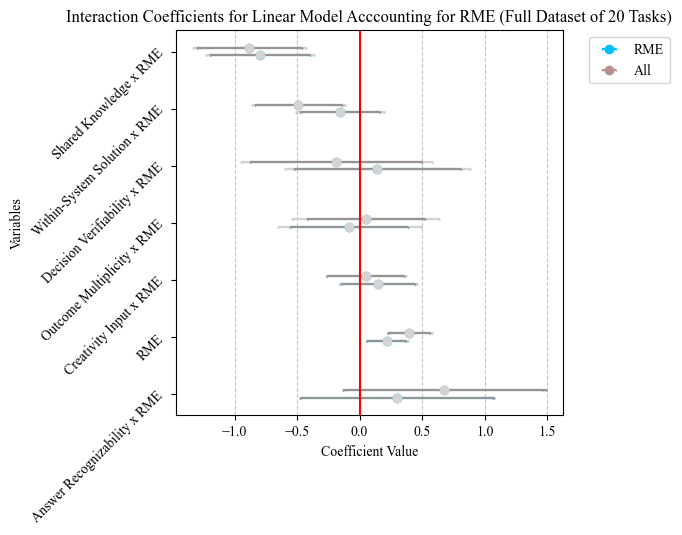

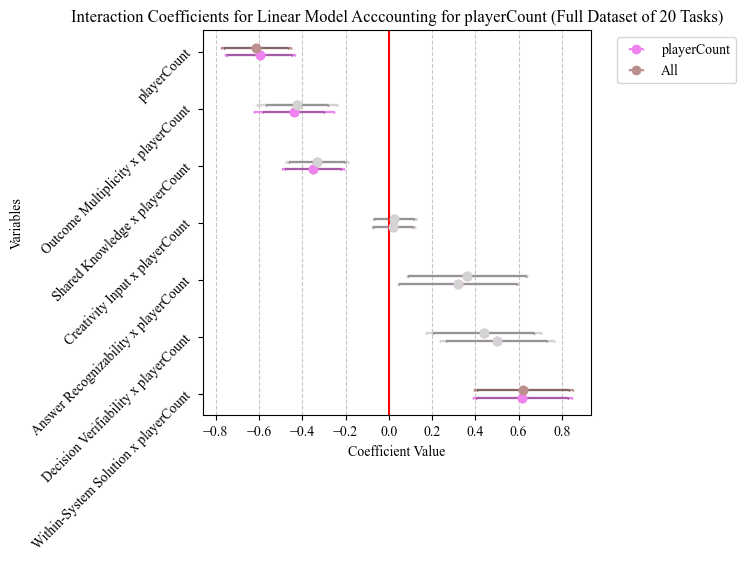

In [62]:
# read in the Q^2 exhaustive search results
# q2_results_path = "./sample_q2_exhaustive_search_outs"
q2_results_path = "./q2_exhaustive_search_outs"
# get all of the filenames in this path
q2_results_files = glob.glob(q2_results_path + "/*.csv")
for file in q2_results_files:
    filename = str(file).split("/")[-1]
    results_df = pd.read_csv(file)

    # get the top features and the Q^2 values associated with it
    maxq2_task_cols = list(ast.literal_eval(results_df.iloc[results_df["q2"].idxmax()]["selected_task_cols"]))
    maxq2_value = np.float64(results_df.iloc[results_df["q2"].idxmax()]["q2"])

    # get basic info: number features, whether it's full or wave1, and the dv
    filename_split = filename.split("/")[-1].split("_")
    num_features = int(filename_split[0])
    is_full = False
    dataset_append = "Wave 1"
    if("FULL" in filename):
        is_full = True
        dataset_append = "Full Data"
   
    # dv
    dv = re.sub("[016789]_", "", filename)
    dv = re.sub("_q2_OLS_from_diff_task_cols", "", dv)
    dv = re.sub("_FULL", "", dv)
    dv = re.sub(".csv", "", dv)

    # Save the top features and the Q^2 values associated with those top features
    if dv not in top_features_dict.keys():
        top_features_dict[dv] = {}
    if num_features not in top_features_dict[dv].keys():
        top_features_dict[dv][num_features] = {"full": {}, "wave1": {}}

    if is_full:
        top_features_dict[dv][num_features]["full"] = {"features": maxq2_task_cols, "q2": maxq2_value}
    else:
        top_features_dict[dv][num_features]["wave1"] = {"features": maxq2_task_cols, "q2": maxq2_value}

    """
    Once we have all the necessary information, we do the following:
    1. Plot "us vs. McGrath" if num_features == 6
    2. Get the set of best-performing features
    3. Fit a linear model with the best-performing features and report Q^2
    4. Fit versions of the linear model with CRT, RME, and playerCount (if num_features == 6?)
    5. Print and Plot the Coefficients for 5 models: 
        (1) task features, 
        (2) task features + CRT, 
        (3) task features + RME, 
        (4) task features + playerCount, 
        (5) task features + CRT + RME + playerCount
    """
    if dv == "score":
        # this is the dataset without conversational features
        if is_full:
            data = team_multi_task_full
            data_composition = team_multi_task_full_with_composition
            mcgrath_comparison = mcgrath_comparisons_full
        else:
            data = team_multi_task_wave1
            data_composition = team_multi_task_wave1_with_composition
            mcgrath_comparison = mcgrath_comparisons_wave1

        # Plot us vs. McGrath
        if(num_features == 6):
            plot_q2_combination_hist(results_df, mcgrath_comparison, "q2", dv, " (Score, " + dataset_append + ")")

        # Linear Models
        if(num_features == 6):
            # Get the interactions that specifically pertained to the task columns
            CRT_and_interactions = ["CRT"] 
            RME_and_interactions = ["RME"]
            playerCount_and_interactions = ["playerCount"]

            for task_col in maxq2_task_cols:
                CRT_and_interactions.append(task_col + " x " + "CRT")
                RME_and_interactions.append(task_col + " x " + "RME")
                playerCount_and_interactions.append(task_col + " x " + "playerCount")

            task_lm = sm.OLS(endog = data_composition["score"], exog=sm.add_constant(data_composition[maxq2_task_cols + controls])).fit()
            task_crt_lm = sm.OLS(endog = data_composition["score"], exog=sm.add_constant(data_composition[maxq2_task_cols + CRT_and_interactions + controls])).fit()
            task_rme_lm = sm.OLS(endog = data_composition["score"], exog=sm.add_constant(data_composition[maxq2_task_cols + RME_and_interactions + controls])).fit()
            task_playercount_lm = sm.OLS(endog = data_composition["score"], exog=sm.add_constant(data_composition[maxq2_task_cols + playerCount_and_interactions + controls])).fit()
            giant_lm = sm.OLS(endog = data_composition["score"], exog=sm.add_constant(data_composition[maxq2_task_cols + CRT_and_interactions + RME_and_interactions + playerCount_and_interactions + controls])).fit()
            
            task_lm, task_crt_lm, task_rme_lm, task_playercount_lm, giant_lm = correct_p_values(task_lm, task_crt_lm, task_rme_lm, task_playercount_lm, giant_lm)
  
            models = [task_lm, task_crt_lm, task_rme_lm, task_playercount_lm, giant_lm]
            print_likelihood_ratio_tests(*models)

            if is_full:
                title_append = " (Full Dataset of 20 Tasks)"
            else:
                title_append = " (Wave 1 Dataset of 10 Tasks)"

            plot_models(models, 
                features_to_plot = list(task_cols_to_use) + controls, 
                model_names=["Task Only", "CRT", "RME", "PlayerCount", "All"], 
                colors=['limegreen', 'salmon', 'deepskyblue', 'violet', 'rosybrown'], 
                title='Task Coefficients from Linear Models Account for CRT, RME, and PlayerCount' + title_append, 
                figsize = (5, 5))
            plot_models([task_crt_lm, giant_lm], 
                features_to_plot=CRT_and_interactions, 
                model_names=["CRT", "All"], 
                colors=['salmon', 'rosybrown'], 
                title='Interaction Coefficients for Linear Model Acccounting for CRT' + title_append, 
                figsize = (5, 5))
            plot_models([task_rme_lm, giant_lm], 
                features_to_plot=RME_and_interactions, 
                model_names=["RME", "All"], 
                colors=['deepskyblue', 'rosybrown'], 
                title='Interaction Coefficients for Linear Model Acccounting for RME' + title_append, 
                figsize = (5, 5))
            plot_models([task_playercount_lm, giant_lm], 
                features_to_plot=playerCount_and_interactions, 
                model_names=["playerCount", "All"], 
                colors=['violet', 'rosybrown'], 
                title='Interaction Coefficients for Linear Model Acccounting for playerCount' + title_append, 
                figsize = (5, 5))


    else:
        # this is the dataset WITH conversational features
        if is_full:
            data = team_multi_task_comms_full
            data_composition = team_multi_task_comms_full_with_composition
            mcgrath_comparison = mcgrath_comparisons_conv_full
        else:
            data = team_multi_task_comms_wave1
            data_composition = team_multi_task_comms_wave1_with_composition
            mcgrath_comparison = mcgrath_comparisons_conv_wave1

        # Plot us vs. McGrath
        if(num_features == 6):
            plot_q2_combination_hist(results_df, mcgrath_comparison, "q2", dv, " (" + comm_dv_translation[dv] + ", " + dataset_append + ")")

In [49]:
# Stargazer([task_lm, task_crt_lm, task_rme_lm, task_playercount_lm, giant_lm])

# Take a look at a summary of our results

In [56]:
top_features_dict

{'turn_taking_index': {6: {'full': {'features': ['Type 2 (Generate)',
     'Solution Scheme Multiplicity',
     'Shared Knowledge',
     'Time Solvability',
     'Type 3 and Type 4 (Objective Correctness)',
     'Conflicting Tradeoffs'],
    'q2': 0.2574313297233865},
   'wave1': {'features': ['Type 2 (Generate)',
     'Divisible-Unitary',
     'Outcome Multiplicity',
     'Answer Recognizability',
     'Type 3 and Type 4 (Objective Correctness)',
     'Creativity Input'],
    'q2': 0.1401167631895041}},
  7: {'full': {'features': ['Type 2 (Generate)',
     'Type 8 (Performance)',
     'Time Solvability',
     'Type 3 and Type 4 (Objective Correctness)',
     'Conflicting Tradeoffs',
     'Solution Scheme Outcome Uncertainty',
     'Creativity Input'],
    'q2': 0.2573144536907161},
   'wave1': {'features': ['Type 1 (Planning)',
     'Type 8 (Performance)',
     'Divisible-Unitary',
     'Time Solvability',
     'Type 3 and Type 4 (Objective Correctness)',
     'Eureka Question',
     

### Compare features and Q^2 selected for a given feature set size

In [63]:
def get_top_features(feat_num_to_select, dataset_type):
    assert(dataset_type in ["full", "wave1"])

    features_for_each_dv = [top_features_dict[dv][feat_num_to_select][dataset_type]['features'] for dv in top_features_dict.keys()]
    df_features_for_each_dv = pd.DataFrame(features_for_each_dv, index=top_features_dict.keys()).T
    return df_features_for_each_dv

In [68]:
def get_top_q2_performance(feat_num_to_select, dataset_type):
    assert(dataset_type in ["full", "wave1"])
    q2_for_each_dv = [round(top_features_dict[dv][feat_num_to_select][dataset_type]['q2'],3) for dv in top_features_dict.keys()]
    df_q2_for_each_dv = pd.DataFrame(q2_for_each_dv, index=top_features_dict.keys()).T

    return df_q2_for_each_dv

In [64]:
get_top_features(7, "full")

,turn_taking_index,sum_num_messages,score,gini_coefficient_sum_num_messages,average_positive_bert,team_burstiness
0,Type 2 (Generate),Conceptual-Behavioral,Type 2 (Generate),Conceptual-Behavioral,Conceptual-Behavioral,Conceptual-Behavioral
1,Type 8 (Performance),Outcome Multiplicity,Outcome Multiplicity,Type 1 (Planning),Type 1 (Planning),Type 7 (Battle)
2,Time Solvability,Answer Recognizability,Decision Verifiability,Divisible-Unitary,Outcome Multiplicity,Outcome Multiplicity
3,Type 3 and Type 4 (Objective Correctness),Conflicting Tradeoffs,Shared Knowledge,Outcome Multiplicity,Shared Knowledge,Time Solvability
4,Conflicting Tradeoffs,Intellectual-Manipulative,Within-System Solution,Answer Recognizability,Time Solvability,Conflicting Tradeoffs
5,Solution Scheme Outcome Uncertainty,Intellective-Judgmental,Type 3 and Type 4 (Objective Correctness),Intellectual-Manipulative,Eureka Question,Intellectual-Manipulative
6,Creativity Input,Creativity Input,Creativity Input,Creativity Input,Creativity Input,Creativity Input


In [69]:
get_top_q2_performance(7, "full")

,turn_taking_index,sum_num_messages,score,gini_coefficient_sum_num_messages,average_positive_bert,team_burstiness
0,0.257,0.326,0.807,0.298,0.214,0.068


In [66]:
get_top_features(6, "full")

,turn_taking_index,sum_num_messages,score,gini_coefficient_sum_num_messages,average_positive_bert,team_burstiness
0,Type 2 (Generate),Conceptual-Behavioral,Outcome Multiplicity,Conceptual-Behavioral,Outcome Multiplicity,Conceptual-Behavioral
1,Solution Scheme Multiplicity,Outcome Multiplicity,Decision Verifiability,Outcome Multiplicity,Shared Knowledge,Type 5 (Cognitive Conflict)
2,Shared Knowledge,Answer Recognizability,Shared Knowledge,Conflicting Tradeoffs,Within-System Solution,Outcome Multiplicity
3,Time Solvability,Conflicting Tradeoffs,Within-System Solution,Intellectual-Manipulative,Answer Recognizability,Time Solvability
4,Type 3 and Type 4 (Objective Correctness),Intellectual-Manipulative,Answer Recognizability,Intellective-Judgmental,Conflicting Tradeoffs,Intellectual-Manipulative
5,Conflicting Tradeoffs,Creativity Input,Creativity Input,Creativity Input,Creativity Input,Creativity Input


In [70]:
get_top_q2_performance(6, "full")

,turn_taking_index,sum_num_messages,score,gini_coefficient_sum_num_messages,average_positive_bert,team_burstiness
0,0.257,0.326,0.806,0.297,0.212,0.068


In [65]:
get_top_features(7, "wave1")

,turn_taking_index,sum_num_messages,score,gini_coefficient_sum_num_messages,average_positive_bert,team_burstiness
0,Type 1 (Planning),Type 1 (Planning),Type 5 (Cognitive Conflict),Type 5 (Cognitive Conflict),Type 1 (Planning),Type 5 (Cognitive Conflict)
1,Type 8 (Performance),Optimizing,Type 7 (Battle),Type 7 (Battle),Type 2 (Generate),Divisible-Unitary
2,Divisible-Unitary,Outcome Multiplicity,Type 8 (Performance),Shared Knowledge,Outcome Multiplicity,Solution Scheme Multiplicity
3,Time Solvability,Shared Knowledge,Maximizing,Answer Recognizability,Conflicting Tradeoffs,Decision Verifiability
4,Type 3 and Type 4 (Objective Correctness),Type 3 and Type 4 (Objective Correctness),Optimizing,Solution Scheme Outcome Uncertainty,Solution Scheme Outcome Uncertainty,Shared Knowledge
5,Eureka Question,Conflicting Tradeoffs,Time Solvability,Eureka Question,Eureka Question,Time Solvability
6,Creativity Input,Creativity Input,Intellective-Judgmental,Intellective-Judgmental,Creativity Input,Intellective-Judgmental


In [71]:
get_top_q2_performance(7, "wave1")

,turn_taking_index,sum_num_messages,score,gini_coefficient_sum_num_messages,average_positive_bert,team_burstiness
0,0.14,0.298,0.704,0.258,0.225,0.051


In [67]:
get_top_features(6, "wave1")

,turn_taking_index,sum_num_messages,score,gini_coefficient_sum_num_messages,average_positive_bert,team_burstiness
0,Type 2 (Generate),Type 1 (Planning),Type 2 (Generate),Type 7 (Battle),Outcome Multiplicity,Conceptual-Behavioral
1,Divisible-Unitary,Outcome Multiplicity,Type 5 (Cognitive Conflict),Outcome Multiplicity,Shared Knowledge,Type 2 (Generate)
2,Outcome Multiplicity,Decision Verifiability,Within-System Solution,Conflicting Tradeoffs,Conflicting Tradeoffs,Type 5 (Cognitive Conflict)
3,Answer Recognizability,Shared Knowledge,Solution Scheme Outcome Uncertainty,Solution Scheme Outcome Uncertainty,Eureka Question,Outcome Multiplicity
4,Type 3 and Type 4 (Objective Correctness),Type 3 and Type 4 (Objective Correctness),Intellectual-Manipulative,Eureka Question,Intellective-Judgmental,Time Solvability
5,Creativity Input,Conflicting Tradeoffs,Intellective-Judgmental,Creativity Input,Creativity Input,Intellective-Judgmental


In [72]:
get_top_q2_performance(6, "wave1")

,turn_taking_index,sum_num_messages,score,gini_coefficient_sum_num_messages,average_positive_bert,team_burstiness
0,0.14,0.298,0.704,0.258,0.225,0.051
